In [14]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import re
import colorsys
from scipy.ndimage import zoom

In [2]:
data = [
    ["orange", "hood", 10],
    ["dark green", "front door", 20],
    ["yellow", "rear door", 30],
    ["cyan", "frame", 40],
    ["purple", "rear quarter panel", 50],
    ["light green", "trunk lid", 60],
    ["blue", "fender", 70],
    ["pink", "bumper", 80],
    ["no color", "rest of car", 90],
    ["white", "background", 0]
]

color_to_hue = {
    "orange": 30,
    "dark green": 120,
    "yellow": 60,
    "cyan": 180,
    "purple": 270,
    "light green": 150,
    "blue": 210,
    "pink": 330,
    #TODO: change this to black later
    "no color": 0, 
    "white": 1,
}

#, row[1] this can be put into the thing too
class_decode_dict = {row[2]: color_to_hue.get(row[0], row[0]) for row in data}
class_decode_dict

{10: 30,
 20: 120,
 30: 60,
 40: 180,
 50: 270,
 60: 150,
 70: 210,
 80: 330,
 90: 0,
 0: 1}

In [16]:
def filter_files_by_regex(directory, pattern):
    # Use os.listdir() to get a list of all files and directories in the specified directory
    file_list = os.listdir(directory)

    # Use a list comprehension to filter the files based on the regex pattern
    filtered_files = [filename for filename in file_list if re.match(pattern, filename)]

    return filtered_files

In [17]:
def load_numpy_arrays(directory, file_names):
    # Create an empty list to store the numpy arrays
    arrays = []
    
    # Iterate through the file names
    for filename in file_names:
        # Load the numpy array from the file path
        array = np.load(directory + filename)
        #new_shape = (64, 64)
        #resized_data = zoom(data, (new_shape[0] / data.shape[0], new_shape[1] / data.shape[1]), order=1).astype(np.int16)
        # Append the array to the list
        arrays.append(array)

    return arrays

In [18]:
def construct_x_y_arrays(arrays):
    arrays_x = [x[:,:,:3] for x in arrays]
    arrays_y = [x[:,:,3:] for x in arrays]
                
    return arrays_x,arrays_y

In [19]:
directory_path = './data/arrays/'
# regex_pattern = r'black_5_doors_[0-9]*\.npy'
regex_pattern = r'orange_3_doors_[0-9]*\.npy'
black_car_image_file_names = sorted(filter_files_by_regex(directory_path, regex_pattern))

for filename in black_car_image_file_names:
    print(filename)
    break

orange_3_doors_0001.npy


In [20]:
numpy_arrays = load_numpy_arrays(directory_path, black_car_image_file_names)

In [21]:
numpy_arraysx, numpy_arraysy = construct_x_y_arrays(numpy_arrays[:10])


In [22]:
def show_image(image):
    # Extract the image data from the last channel (the alpha channel, for example)
    image_data = image[:, :]
    
    # Display the image using Matplotlib
    plt.imshow(image_data)  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off the axis labels and ticks
    plt.show()

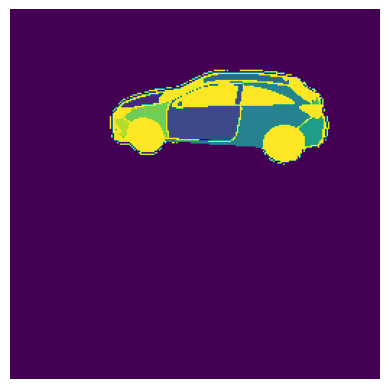

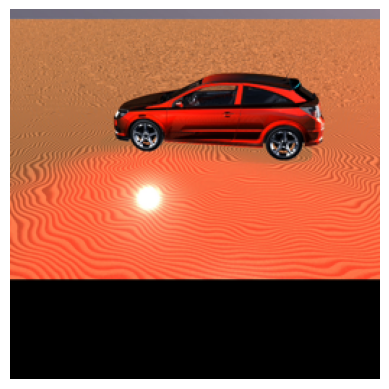

In [23]:
show_image(numpy_arraysy[0])
show_image(numpy_arraysx[0])


# Unet definition

In [24]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Dropout,\
                                    Lambda, Conv2DTranspose, Add
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import os


imshape = (256, 256, 3)
n_classes = len(data)


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def unet(pretrained=False, base=4):

    if pretrained:
        path = os.path.join('models', model_name+'.model')
        if os.path.exists(path):
            model = load_model(path, custom_objects={'dice': dice})
            model.summary()
            return model
        else:
            print('Failed to load existing model at: {}'.format(path))

    if n_classes == 1:
        loss = 'binary_crossentropy'
        final_act = 'sigmoid'
    elif n_classes > 1:
        loss = 'categorical_crossentropy'
        final_act = 'softmax'

    b = base
    i = Input((imshape[0], imshape[1], imshape[2]))
    s = Lambda(lambda x: preprocess_input(x)) (i)

    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    o = Conv2D(n_classes, (1, 1), activation=final_act) (c9)

    model = Model(inputs=i, outputs=o, name=model_name)
    model.compile(optimizer=Adam(1e-4),
                  loss=loss,
                  metrics=[dice])
    model.summary()

    return model

In [25]:
import numpy as np
import pickle
import os
from PIL import Image

import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import json
import tensorflow as tf


ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Multiply((1.2, 1.5)),
    iaa.Affine(
        #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        rotate=(-90, 90)
    ),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 8))
    )
], random_order=True)


class DataGenerator(tf.keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, image_paths, annot_paths, batch_size=32,
                 shuffle=True, augment=False):
        self.image_paths = image_paths
        self.annot_paths = annot_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()


    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.image_paths) / self.batch_size))


    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        image_paths = [self.image_paths[k] for k in indexes]
        annot_paths = [self.annot_paths[k] for k in indexes]

        X, y = self.__data_generation(image_paths, annot_paths)

        return X, y


    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def get_poly(self, annot_path):
        # reads in shape_dicts
        with open(annot_path) as handle:
            data = json.load(handle)

        shape_dicts = data['shapes']

        return shape_dicts


    def create_binary_masks(self, im, shape_dicts):
        # image must be grayscale
        blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)

        for shape in shape_dicts:
            if shape['label'] != 'background':
                points = np.array(shape['points'], dtype=np.int32)
                cv2.fillPoly(blank, [points], 255)
        blank = blank / 255.0

        return np.expand_dims(blank, axis=2)


    def create_multi_masks(self, im, shape_dicts):

        channels = []
        cls = [x['label'] for x in shape_dicts]
        poly = [np.array(x['points'], dtype=np.int32) for x in shape_dicts]
        label2poly = dict(zip(cls, poly))
        background = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)

        # iterate through objects of interest
        for i, label in enumerate(labels):

            blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)

            if label in cls:
                cv2.fillPoly(blank, [label2poly[label]], 255)
                cv2.fillPoly(background, [label2poly[label]], 255)

            channels.append(blank)

        # handle an image where only background is present
        if 'background' in cls:
            background = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
            cv2.fillPoly(background, [label2poly['background']], 255)
        else:
            _, background = cv2.threshold(background, 127, 255, cv2.THRESH_BINARY_INV)
        channels.append(background)

        Y = np.stack(channels, axis=2) / 255.0

        return Y


    def augment_poly(self, im, shape_dicts):
        # augments an image and it's polygons

        points = []
        aug_shape_dicts = []
        i = 0

        for shape in shape_dicts:

            for pairs in shape['points']:
                points.append(ia.Keypoint(x=pairs[0], y=pairs[1]))

            _d = {}
            _d['label'] = shape['label']
            _d['index'] = (i, i+len(shape['points']))
            aug_shape_dicts.append(_d)

            i += len(shape['points'])

        keypoints = ia.KeypointsOnImage(points, shape=(256,256,3))

        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images([im])[0]
        keypoints_aug = seq_det.augment_keypoints([keypoints])[0]

        for shape in aug_shape_dicts:
            start, end = shape['index']
            aug_points = [[keypoint.x, keypoint.y] for keypoint in keypoints_aug.keypoints[start:end]]
            shape['points'] = aug_points

        return image_aug, aug_shape_dicts


    #TODO: This is where the data is generated I need to change this to the one I wrote above^
    def __data_generation(self, image_paths, annot_paths):

        X = np.empty((self.batch_size, imshape[0], imshape[1], imshape[2]), dtype=np.float32)
        Y = np.empty((self.batch_size, imshape[0], imshape[1], n_classes),  dtype=np.float32)

        for i, (im_path, annot_path) in enumerate(zip(image_paths, annot_paths)):

            # read image as grayscale or rgb
            if imshape[2] == 1:
                im = cv2.imread(im_path, 0)
                im = np.expand_dims(im, axis=2)
            elif imshape[2] == 3:
                im = cv2.imread(im_path, 1)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            shape_dicts = self.get_poly(annot_path)

            # check for augmentation
            if self.augment:
                im, shape_dicts = self.augment_poly(im, shape_dicts)

            # create target masks
            if n_classes == 1:
                mask = self.create_binary_masks(im, shape_dicts)
            elif n_classes > 1:
                mask = self.create_multi_masks(im, shape_dicts)

            X[i,] = im
            Y[i,] = mask

        return X, Y

ModuleNotFoundError: No module named 'config'

In [ ]:
import os
#TODO: Make tensorflow work
#TODO: make the data generator work, 
# Keras no longer in tensorflow? checkout how that works
# from tensorboard_callbacks import TrainValTensorBoard, TensorBoardMask



def sorted_fns(dir):
    return sorted(os.listdir(dir), key=lambda x: int(x.split('.')[0]))



image_paths = [os.path.join('images', x) for x in sorted_fns('images')]
annot_paths = [os.path.join('annotated', x) for x in sorted_fns('annotated')]

model = unet(pretrained=False, base=4)


tg = DataGenerator(image_paths=image_paths, annot_paths=annot_paths,
                   batch_size=5, augment=True)

# checkpoint = ModelCheckpoint(os.path.join('models', model_name+'.model'), monitor='dice', verbose=1, mode='max',
#                              save_best_only=True, save_weights_only=False, period=10)
# 
# train_val = TrainValTensorBoard(write_graph=True)
# tb_mask = TensorBoardMask(log_freq=10)

model.fit_generator(generator=tg,
                    steps_per_epoch=len(tg),
                    epochs=500, verbose=1,
                    # callbacks=[checkpoint, train_val, tb_mask]
                    )